# **Assignment 1: Loading and showing CT-scans in DICOM format**

## **1. Importing libraries**

We need pydicom library to read dicom images

In [1]:
!pip install pydicom
!pip install tabulate
!pip install seaborn
import pydicom
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from zipfile import ZipFile
import os
from tabulate import tabulate
import copy
import seaborn as sns

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.0 MB/s eta 0:00:00


## **2. Data access and preprocessing**

**Information**:

The 3D-IRCADb-01 database is composed of the 3D CT-scans of 10 women and 10 men with hepatic tumours in 75% of cases. The 20 folders correspond to 20 different patients, which can be downloaded individually or conjointly. The table below provides information on the image, such as liver size (width, depth, height) or the location of tumours according to Couninaud’s segmentation. It also indicates the major difficulties liver segmentation software may encounter due to the contact with neighbouring organs, an atypical shape or density of the liver, or even artefacts in the image.

These folders are called “3D-IRCADb-1-number” (the number varying between 01 and 20).. These folders are called “3D-IRCADb-01-number” (the number varying between 01 and 20). Each “3D-IRCADb-01-number” folder contains 4 sub-folders called “PATIENT_DICOM”, “LABELLED_DICOM”, “MASKS_DICOM” and “MESHES_VTK”. These folders respectively contain the anonymized patient image in DICOM format, the labelled image corresponding to the various zones of interest segmented in DICOM format, a new set of sub-folders corresponding to the names of the various segmented zones of interest containing the DICOM image of each mask, and finally, all the files corresponding to surface meshes of the various zones of interest in VTK format.

In [2]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
!cd /content/gdrive/MyDrive

In [4]:
!unzip '/content/gdrive/MyDrive/3Dircadb1.zip'

Archive:  /content/gdrive/MyDrive/3Dircadb1.zip
   creating: 3Dircadb1/
   creating: 3Dircadb1/3Dircadb1.1/
 extracting: 3Dircadb1/3Dircadb1.1/LABELLED_DICOM.zip  
 extracting: 3Dircadb1/3Dircadb1.1/LICENSE.txt  
 extracting: 3Dircadb1/3Dircadb1.1/MASKS_DICOM.zip  
 extracting: 3Dircadb1/3Dircadb1.1/MESHES_VTK.zip  
 extracting: 3Dircadb1/3Dircadb1.1/PATIENT_DICOM.zip  
 extracting: 3Dircadb1/3Dircadb1.1/liver_01.jpg  
   creating: 3Dircadb1/3Dircadb1.10/
 extracting: 3Dircadb1/3Dircadb1.10/LABELLED_DICOM.zip  
 extracting: 3Dircadb1/3Dircadb1.10/LICENSE.txt  
 extracting: 3Dircadb1/3Dircadb1.10/MASKS_DICOM.zip  
 extracting: 3Dircadb1/3Dircadb1.10/MESHES_VTK.zip  
 extracting: 3Dircadb1/3Dircadb1.10/PATIENT_DICOM.zip  
 extracting: 3Dircadb1/3Dircadb1.10/liver_10.jpg  
   creating: 3Dircadb1/3Dircadb1.11/
 extracting: 3Dircadb1/3Dircadb1.11/LABELLED_DICOM.zip  
 extracting: 3Dircadb1/3Dircadb1.11/LICENSE.txt  
 extracting: 3Dircadb1/3Dircadb1.11/MASKS_DICOM.zip  
 extracting: 3Dircadb

In [5]:
%cd 3Dircadb1
!ls

/content/3Dircadb1
3Dircadb1.1   3Dircadb1.12  3Dircadb1.15  3Dircadb1.18	3Dircadb1.20  3Dircadb1.5  3Dircadb1.8
3Dircadb1.10  3Dircadb1.13  3Dircadb1.16  3Dircadb1.19	3Dircadb1.3   3Dircadb1.6  3Dircadb1.9
3Dircadb1.11  3Dircadb1.14  3Dircadb1.17  3Dircadb1.2	3Dircadb1.4   3Dircadb1.7


In [6]:
patient_paths = glob('3Dircadb1.*')

In [7]:
patient_paths

['3Dircadb1.4',
 '3Dircadb1.12',
 '3Dircadb1.18',
 '3Dircadb1.1',
 '3Dircadb1.19',
 '3Dircadb1.15',
 '3Dircadb1.2',
 '3Dircadb1.10',
 '3Dircadb1.11',
 '3Dircadb1.8',
 '3Dircadb1.16',
 '3Dircadb1.7',
 '3Dircadb1.5',
 '3Dircadb1.14',
 '3Dircadb1.20',
 '3Dircadb1.17',
 '3Dircadb1.6',
 '3Dircadb1.9',
 '3Dircadb1.13',
 '3Dircadb1.3']

Unzip patient_paths

In [8]:
with ZipFile('/content/gdrive/MyDrive/3Dircadb1.zip', 'r') as zipObj:
   # Get a list of all archived file names from the zip
   zipObj.extractall()


In [9]:
! rm '/content/3Dircadb1/3Dircadb1/' -r

In [10]:
%cd ".."

/content


In [11]:
%cd  3Dircadb1

/content/3Dircadb1


In [12]:
# rename subdirectory from '3Dircadb1/3Dircadb1/3Dircadb1.1' to 1, and so on
for i in range(20):
  os.rename('3Dircadb1.'+str(i+1), str(i+1))

In [13]:
# unzip all files
for i in range(20):
    # for each subdirectory '3Dircadb1/{i+1}', unzip all files with zip format
    parent = f'/content/3Dircadb1/{i+1}'
    # unzip all files in parent
    for file in os.listdir(parent):
        if file.endswith('.zip'):
            # extract file without letting the original parent folder back
            with ZipFile(os.path.join(parent, file), 'r') as zipObj:
                zipObj.extractall(parent)

## **3. Contents**

### **3.1. Load CT-Scans from the dataset (using Dicom library)**

In [14]:
!ls

1  10  11  12  13  14  15  16  17  18  19  2  20  3  4	5  6  7  8  9


In [109]:
img_path = '/content/3Dircadb1/1/PATIENT_DICOM/image_128'
#img_path = '3Dircadb1/1/PATIENT_DICOM/image_128'

Here we show some information about the dcm_format of an dicom image

In [110]:
def read_dcom(img_path):
  dcm_img = pydicom.dcmread(img_path, force=True)
  return dcm_img


# Show image from dicom format
def show_dicom_image(image):
  plt.axis("off")
  plt.imshow(image.pixel_array)

In [111]:
dcm_format = read_dcom(img_path)
dcm_format

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 256
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.2.1125.5056068985851841460466652605700936873
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.2.1143.107.104.103.115.2.1.0.126.124.113
(0002, 0013) Implementation Version Name         SH: 'GDCM 2.1.0'
(0002, 0016) Source Application Entity Title     AE: 'GDCM/VTK 5.4.0'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.2.1125.5056068985851841460466652605700936

Randomly show an image with the help of **windowing** technique

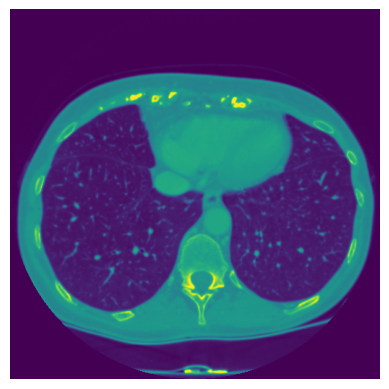

In [112]:
show_dicom_image(dcm_format)

### **3.2. Transform CT-Scans in HU to grayscale images**

**Some useful range**

Bone:

    min_range = 600
    max_range = 3000

Fat:

    min_range = -100
    max_range = -50

Spleen, pancreas or kidney:

    min_range = 40
    max_range = 100
  
Liver:

    min_range = -20
    max_range = 150

Lung:

    min_range = -900
    max_range = -700

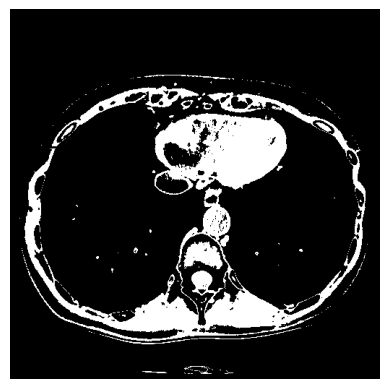

In [121]:
# gray scale
def show_in_gray_scale(image):
  plt.axis("off")
  plt.imshow(image ,cmap = "gist_gray")

# Transform dicom format to hu_image
def transform_to_hu(medical_image):

    intercept = medical_image.RescaleIntercept
    slope = medical_image.RescaleSlope
    hu_image = medical_image.pixel_array* slope + intercept

    return hu_image

# Windowing to focus for viewing each organization
def window_image(image, min_range, max_range):

    window_image = np.ones_like(image)*255
    window_image[image < min_range] = 0
    window_image[image > max_range] = 0
    X_store = []
    Y_store = []
    for i in range(window_image.shape[0]):
        for j in range(window_image.shape[1]):
            if (window_image[i,j] > 0):
                X_store.append(j)
                Y_store.append(i)

    return window_image,X_store,Y_store


# Show organisation image
def show_organization_image(image_path, organism = "bone"):
  dcm_format  = read_dcom(image_path)
  hu_image = transform_to_hu(dcm_format)
  min_range = 0
  max_range = 0
  if (organism == "bone"):
    min_range = 600
    max_range = 3000
  elif (organism == "fat"):
    min_range = -100
    max_range = -50
  elif (organism == "spleen" or organism == "pancreas" or organism == "kidney"):
    min_range = 40
    max_range = 100
  elif (organism == "liver"):
    min_range = 0
    max_range = 200
  elif (organism == "lung"):
    min_range = -500
    max_range = 0

  orga_image,X,Y = window_image(hu_image, min_range, max_range)

  show_in_gray_scale(orga_image)
  return hu_image,X, Y


hu_image, X_bone, Y_bone = show_organization_image(img_path, "liver")

In [ ]:
# masking color of organisation on hu-format images
def show_color_masking(hu_image, X_store, Y_store):
  plt.axis("off")
  plt.imshow(hu_image, cmap = "gist_gray")
  plt.scatter(X_store, Y_store, color='blue', s=4)

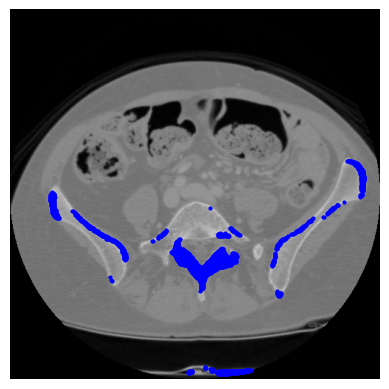

In [ ]:
show_color_masking(hu_image,X_bone,Y_bone)

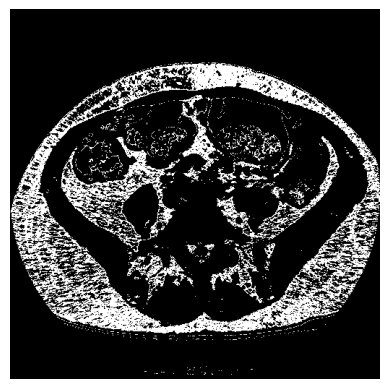

In [ ]:
hu_image, X_fat, Y_fat = show_organization_image(img_path, "fat")

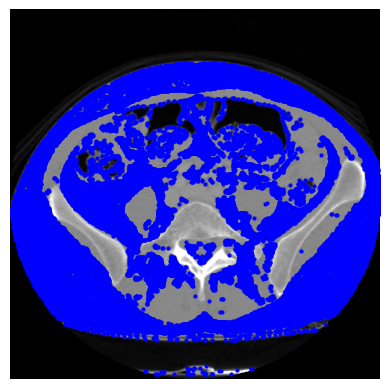

In [ ]:
show_color_masking(hu_image,X_fat,Y_fat)

Another image from patient 2

In [57]:
img_path = '/content/3Dircadb1/2/PATIENT_DICOM/image_40'
# img_path = '3Dircadb1/2/PATIENT_DICOM/image_40'

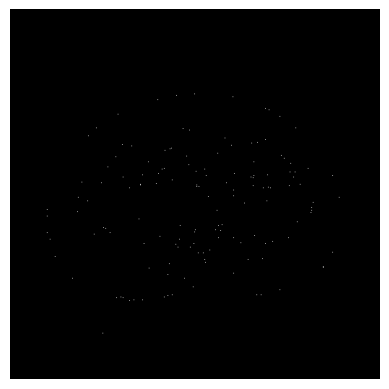

In [ ]:
hu_image, X_blood, Y_blood = show_organization_image(img_path, "blood")

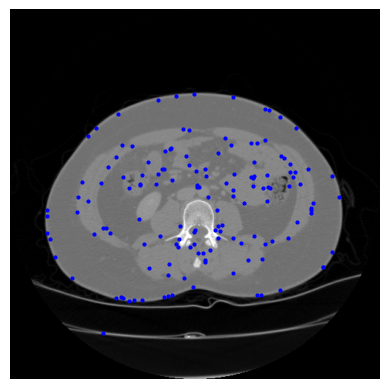

In [ ]:
show_color_masking(hu_image,X_blood,Y_blood)

Show lung part of the image

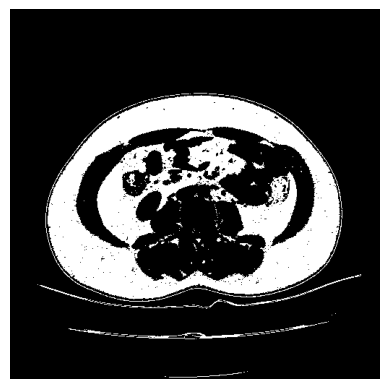

In [58]:
hu_image, X_lung, Y_lung = show_organization_image(img_path, "liver")

Use masking technique to demonstrate the lung part of the image

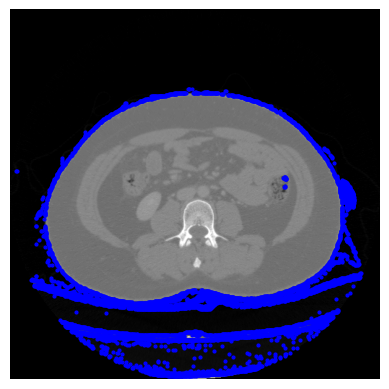

In [ ]:
show_color_masking(hu_image,X_lung,Y_lung)

### **3.3. Show image (Slices in CT_Scan) as in the following pictures**

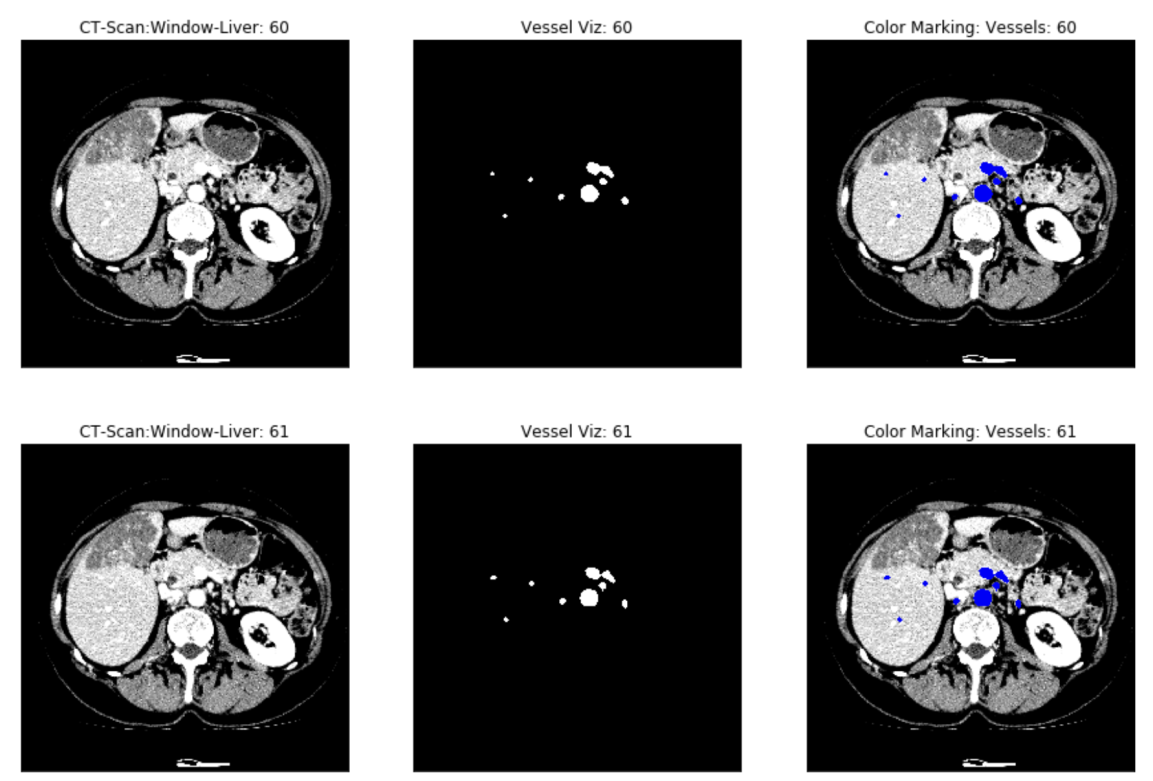

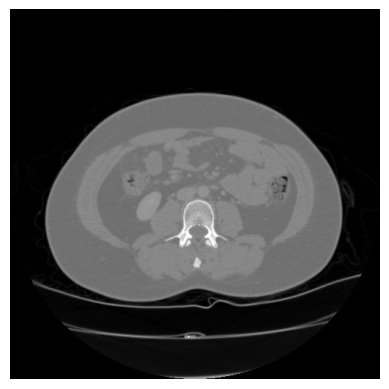

In [ ]:
# img_path = '/content/gdrive/MyDrive/3Dircadb1/1/PATIENT_DICOM/image_72'
dcm_format = read_dcom(img_path)
show_in_gray_scale(dcm_format.pixel_array)

Show artery of patient 1, image 72

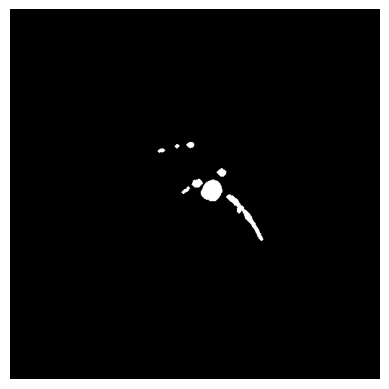

In [ ]:
label_path = '/content/3Dircadb1/1/MASKS_DICOM/artery/image_72'
# label_path = '3Dircadb1/1/MASKS_DICOM/artery/image_128'
dcm_format = read_dcom(label_path)
show_in_gray_scale(dcm_format.pixel_array)

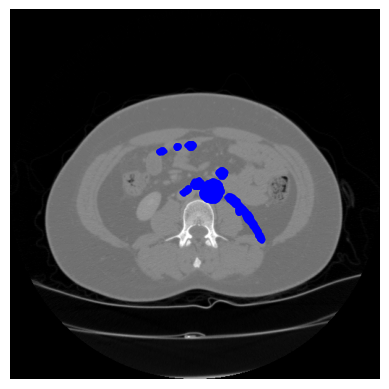

In [ ]:
Y, X = np.where(dcm_format.pixel_array == 255)
show_color_masking(hu_image,X, Y)

### **3.4. Do some statistical analysis**

#### **a. Number of pixels**

For example, patient 3

In [ ]:
patient_id = 3

In [ ]:
img_paths = glob(f'/content/3Dircadb1/{patient_id}/MASKS_DICOM/*')
# img_paths = glob(f'3Dircadb1/{patient_id}/MASKS_DICOM/*')

In [ ]:
labels_name     = []
number_of_pixels = []

for path in img_paths:
  organism_paths = glob(f'{path}/*')
  #print(organism_paths)
  labels_name.append(os.path.split(path)[1])
  sum_pixels = 0

  for organism_path in organism_paths:
    dcm_format = read_dcom(organism_path)
    sum_pixels += np.sum(dcm_format.pixel_array)

  print(sum_pixels)
  number_of_pixels.append(sum_pixels)

107699.0
119700570.0
1228029.0
3634260.0
29564700.0
985769.0
74257.0
79298.0
1123194.0
605645145.0
13260.0
30176322.0
338459.0


Number of pixels of each organisation

In [ ]:
def print_tabular(lst_data, lst_name, string_name):
  print(string_name)
  new_list = []
  new_list = copy.deepcopy(lst_data)
  for i, lst in enumerate(new_list):

    lst.insert(0,lst_name[i])
  print(tabulate(new_list, headers='firstrow', tablefmt='fancy_grid'))

In [ ]:
print_tabular([labels_name, number_of_pixels], ['Organization', 'Number of pixels'], "Total masks pixel statistic:")

Total masks pixel statistic:
╒══════════════════╤════════════╤═════════════╤═════════════╤══════════════╤═════════════════╤════════════╤═════════╤══════════════╤═════════════╤═════════════╤══════════╤═════════════╤══════════╕
│ Organization     │   venacava │     kidneys │   rightlung │   livertumor │   biliarysystem │   leftlung │   metal │   portalvein │        bone │       liver │   Stones │        skin │   spleen │
╞══════════════════╪════════════╪═════════════╪═════════════╪══════════════╪═════════════════╪════════════╪═════════╪══════════════╪═════════════╪═════════════╪══════════╪═════════════╪══════════╡
│ Number of pixels │     107699 │ 1.19701e+08 │ 1.22803e+06 │  3.63426e+06 │     2.95647e+07 │     985769 │   74257 │        79298 │ 1.12319e+06 │ 6.05645e+08 │    13260 │ 3.01763e+07 │   338459 │
╘══════════════════╧════════════╧═════════════╧═════════════╧══════════════╧═════════════════╧════════════╧═════════╧══════════════╧═════════════╧═════════════╧══════════╧════════════

In [ ]:
def draw_bar_chart(x,y, x_label_name, y_label_name, title):
  fig = plt.figure(figsize = (15, 5))

  # creating the bar plot
  plt.bar(x, y,
          width = 0.2)

  plt.xlabel(x_label_name)
  plt.ylabel(y_label_name)
  plt.title(title)
  plt.show()

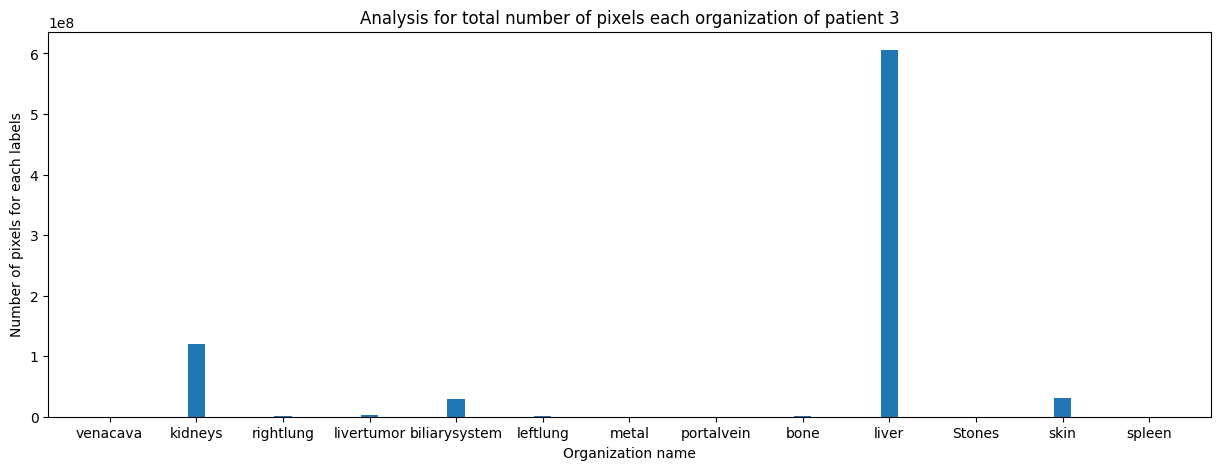

In [ ]:
x_label = "Organization name"
y_label = "Number of pixels for each labels"
title_name = f"Analysis for total number of pixels each organization of patient {patient_id}"
draw_bar_chart(labels_name, number_of_pixels, x_label, y_label, title_name)

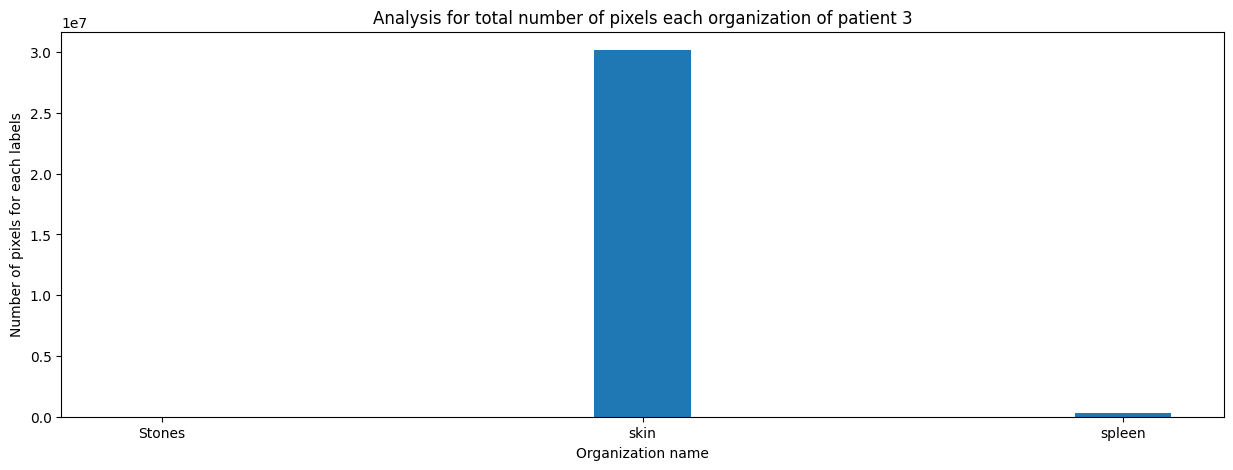

In [ ]:
draw_bar_chart(labels_name[10:], number_of_pixels[10:], x_label, y_label, title_name)

In [ ]:
def draw_percentage(number_of_pixels, string_name):
  print(string_name)
  #percentage_of_each_organization = np.array(number_of_pixels)/np.sum(number_of_pixels)
  plt.figure(figsize=(5, 5))
  plt.pie(number_of_pixels,
    autopct='%1.2f%%',
    textprops={'fontsize':10}, radius = 3, colors=sns.color_palette('Set2'), labels=labels_name)
  plt.legend(labels=labels_name, loc='upper right', bbox_to_anchor=(0, 0))

  plt.show()

Draw circle chart:

Percentage of each organization of patient 3: 




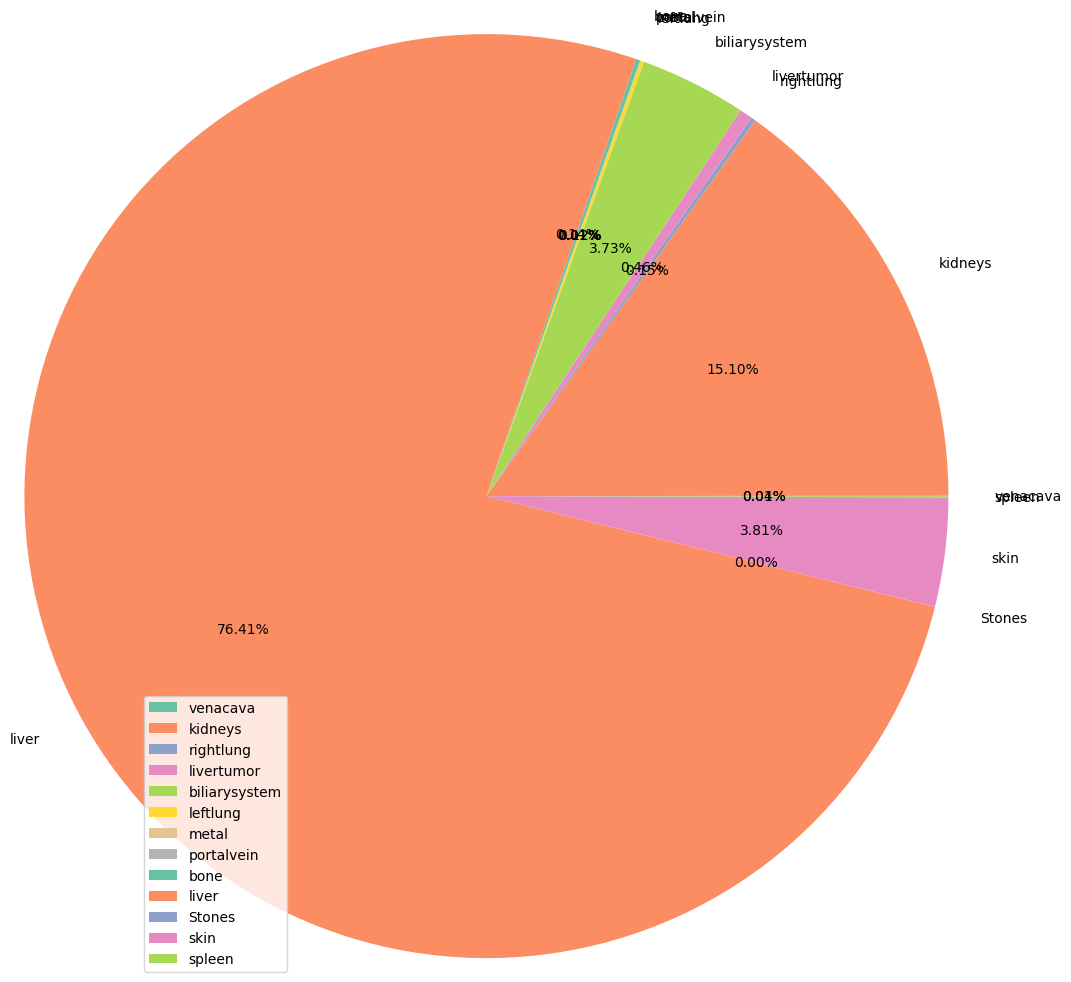

In [ ]:
draw_percentage(number_of_pixels, f'Percentage of each organization of patient {patient_id}: \n\n')

**Conclusion:**

The number of pixels of the liver of patient 3 is largest, with a total of 6.045645e+08 pixels (accounting for 76.41% in total). The second largest one is the kidneys which has 1.119701e+08 (15.10%).

### **b. Number of tumors analysis**

In [ ]:
patients_id_list_paths = sorted(glob(f'/content/3Dircadb1/*'), key = lambda x: int(os.path.split(x)[1]))
# patients_id_list_paths = sorted(glob(f'3Dircadb1/*'), key = lambda x: int(os.path.split(x)[1]))

In [ ]:
patients_id_lst     = []
num_tumors_lst      = []
for path in patients_id_list_paths:
  try:
    num_tumors = 0
    patient_id = int(os.path.split(path)[1])
    patients_id_lst.append(f'{patient_id}')
    img_paths = glob(f'/content/3Dircadb1/{patient_id}/MASKS_DICOM/*')
    # img_paths = glob(f'3Dircadb1/{patient_id}/MASKS_DICOM/*')
    for path in img_paths:
        if "tumor" in os.path.split(path)[1]:
          num_tumors += 1
    num_tumors_lst.append(num_tumors)
  except:
    continue

In [ ]:
print_tabular([patients_id_lst, num_tumors_lst], ['Patient id', 'Number of tumors'], "Number of tumors statistic: ")

Number of tumors statistic: 
╒══════════════════╤═════╤═════╤═════╤═════╤═════╤═════╤═════╤═════╤═════╤══════╤══════╤══════╤══════╤══════╤══════╤══════╤══════╤══════╤══════╤══════╕
│ Patient id       │   1 │   2 │   3 │   4 │   5 │   6 │   7 │   8 │   9 │   10 │   11 │   12 │   13 │   14 │   15 │   16 │   17 │   18 │   19 │   20 │
╞══════════════════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪══════╪══════╪══════╪══════╪══════╪══════╪══════╪══════╪══════╪══════╪══════╡
│ Number of tumors │   7 │   1 │   1 │   1 │   2 │   1 │   1 │   3 │   1 │    1 │    0 │    1 │    1 │    0 │    1 │    1 │    2 │    1 │    1 │    0 │
╘══════════════════╧═════╧═════╧═════╧═════╧═════╧═════╧═════╧═════╧═════╧══════╧══════╧══════╧══════╧══════╧══════╧══════╧══════╧══════╧══════╧══════╛


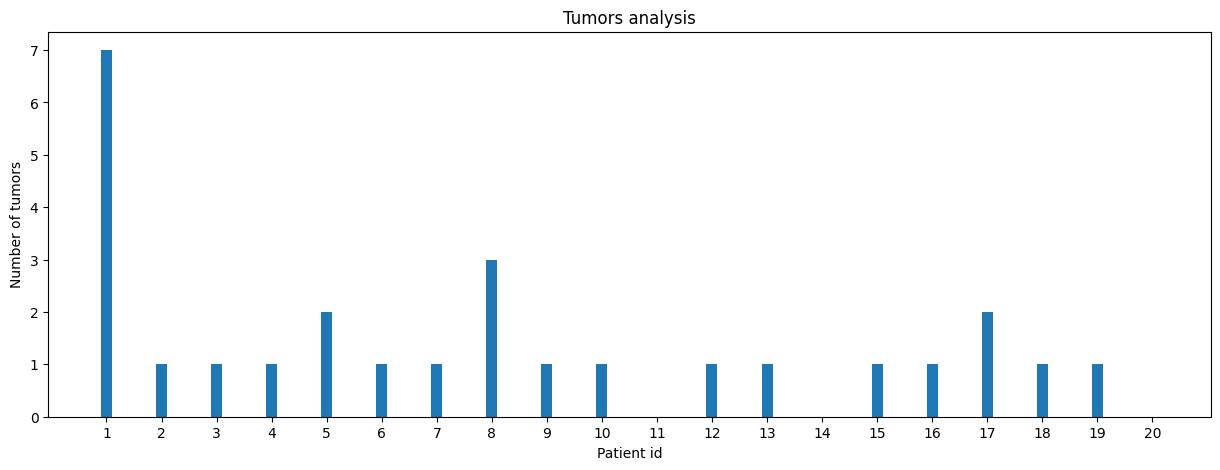

In [ ]:
draw_bar_chart(patients_id_lst,num_tumors_lst, 'Patient id', "Number of tumors", "Tumors analysis")

**Conclusion:**

Number of tumors are not equal between the patients. The patient 1 has largest number of tumors which is 7. While the patient 11 and patient 20 do not have any tumors.

### **c. Size of tumors analysis**

In [ ]:
patients_id_list_paths = sorted(glob(f'/content/3Dircadb1/*'), key = lambda x: int(os.path.split(x)[1]))
# patients_id_list_paths = sorted(glob(f'3Dircadb1/*'), key = lambda x: int(os.path.split(x)[1]))
path_tumors_lst     = []
patient_index       = []
tumor_names       = []
for path in patients_id_list_paths:
  try:
    patient_id = int(os.path.split(path)[1])
    img_paths = glob(f'/content/3Dircadb1/{patient_id}/MASKS_DICOM/*')
    # img_paths = glob(f'3Dircadb1/{patient_id}/MASKS_DICOM/*')
    for path in img_paths:
        if "tumor" in os.path.split(path)[1]:
          patient_index.append(patient_id)
          path_tumors_lst.append(path)
          tumor_names.append(os.path.split(path)[1])
  except:
    continue

In [ ]:
percentage_tumors = []
for path in path_tumors_lst:
  liver = os.path.join(os.path.split(path)[0],'liver')
  liver_path_images = glob(f'{liver}/*')

  liver_pixels = 0
  for liver_path in liver_path_images:
    dcm_format = read_dcom(liver_path)
    liver_pixels += np.sum(dcm_format.pixel_array.astype('bool'))

  tumor_pixels = 0
  tumor_path_images = glob(f'{path}/*')

  for tumor_path in tumor_path_images:
    dcm_format = read_dcom(tumor_path)
    tumor_pixels += np.sum(dcm_format.pixel_array.astype('bool'))


  percentage_tumors.append(tumor_pixels/liver_pixels)


Print out statistical results of livertumor

In [ ]:
print_tabular([patient_index, tumor_names, percentage_tumors], ['Patient id', 'Tumor name', "Size of tumors"], "Size of tumors statistic: ")

Size of tumors statistic: 
╒════════════════╤════════════════════════╤══════════════════════╤═══════════════════════╤═════════════════════╤══════════════════════╤══════════════════════╤══════════════════════╤══════════════════════╤══════════════════════╤══════════════════════╤═══════════════════════╤═══════════════════════╤═════════════════════╤═════════════════════╤═══════════════════════╤════════════════════════╤═════════════════════╤══════════════════════╤══════════════════════╤═════════════════════╤═════════════════════╤═══════════════════════╤══════════════════════╤══════════════════════╤═════════════════════╤═══════════════════════╤════════════════════╕
│ Patient id     │ 1                      │ 1                    │ 1                     │ 1                   │ 1                    │ 1                    │ 1                    │ 2                    │ 3                    │ 4                    │ 5                     │ 5                     │ 6                   │ 7          